In [1]:
# -*- coding: utf-8 -*-
import os,copy,csv,importlib,time,math
import numpy as np
import math,random,shutil
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal
import pickle as pickle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from itertools import cycle
from matplotlib import cm
from scipy.stats import gaussian_kde
colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

In [2]:
#########################################################################################
#set the seed for random environment
#here we set the seed to 45
#########################################################################################
def seed_everything(seed=45):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
#when import the module the seed is set
seed_everything()
    
#########################################################################################
#function: To read the prpd and waveform data from the .txt or .csv file
#input: prpd_name, waveform_name are the full path name of the data file
#output: numpy array of the prpd and waveform data
#     for the prpd, 2*n array, n is the number of the waveform point in prpd
#              row 0 is the amplitude of the prpd, row 1 is the phase of each point
#     for the waveform, n*d array, n is the number of the waveform, d is the length of
#              the waveform
#########################################################################################
def read_data(prpd_name, waveform_name):
    #prepare the raw data
    prpd_raw_data = []
    waveform_raw_data = []
    
    #get the file format
    file_format = prpd_name.split('.')[-1]
    file_format_tmp = waveform_name.split('.')[-1]
    assert file_format == file_format_tmp
    assert os.path.exists(prpd_name) and os.path.exists(waveform_name), 'PRPD or Waveform file not exist!'
    
    #read data flag
    read_flag = True
    
    #get prpd data
    prpd_ampl = list()
    prpd_angle = list()
    waveform_list = list()
    
    if file_format == 'txt':
        try:
            fopen = open(prpd_name)
            prpd_raw_data = fopen.readlines()
            fopen.close()
            for one_ampl in prpd_raw_data[0].split('\t'):
                prpd_ampl.append(np.float32(one_ampl))
            for one_angle in prpd_raw_data[1].split('\t'):
                prpd_angle.append(round(float(one_angle)))

            fopen = open(waveform_name)
            waveform_raw_data = fopen.readlines()
            fopen.close()
            for one_wave in waveform_raw_data:
                waveform_list.append(np.array(one_wave.split('\t'), dtype=np.float16))
            
            read_flag = True
            
        except:
            read_flag = False
        
    elif file_format == 'csv':
        try:
            fopen = open(prpd_name, 'r')
            csvfile = csv.reader(fopen)
            for i in csvfile:
                prpd_raw_data.append(i)
            for one_ampl in prpd_raw_data[0][0].split('\t'):
                prpd_ampl.append(float(one_ampl))
            for one_angle in prpd_raw_data[1][0].split('\t'):
                prpd_angle.append(round(float(one_angle)))
            fopen.close()

            fopen = open(waveform_name, 'r')
            csvfile = csv.reader(fopen)
            for one in csvfile:
                waveform_list.append(np.array(one[0].split('\t'), dtype=np.float16))
            fopen.close()
            read_flag = True
            
            prpd_list = np.array([prpd_ampl,prpd_angle])
            waveform_list = np.array(waveform_list, dtype=np.float16)
            if waveform_list.shape[0]!=len(prpd_angle):
                read_flag = False
                
        except:
            read_flag = False
            
        if read_flag==False:
            prpd_ampl = list()
            prpd_angle = list()
            waveform_list = list()
            waveform_raw_data = list()
            try:
                fopen = open(prpd_name, 'r')
                csvfile = csv.reader(fopen)
                for i in csvfile:
                    prpd_raw_data.append(i)
                prpd_ampl = np.array(prpd_raw_data, dtype=np.float16)[0]
                prpd_angle = np.array(prpd_raw_data, dtype=np.float16)[1]
                fopen.close()    
                
                fopen = open(waveform_name, 'r')
                csvfile = csv.reader(fopen)
                for one in csvfile:
                    waveform_list.append(np.array(one, dtype=np.float16))
                fopen.close()
                read_flag = True
                prpd_list = np.array([prpd_ampl,prpd_angle])
                waveform_list = np.array(waveform_list, dtype=np.float16)
                if waveform_list.shape[0]!=len(prpd_angle):
                    read_flag = False

            except:
                read_flag = False
            
    else:
        raise Exception('data file only support: txt or csv!')

    if read_flag==False:
        raise Exception('data file read error!')
    
    prpd_list = np.array([prpd_ampl,prpd_angle], dtype=np.float32).swapaxes(0,1)#trans to n*2 array
    waveform_list = np.array(waveform_list, dtype=np.float32)
    
    assert len(prpd_ampl)==len(prpd_angle)
    assert waveform_list.shape[0]==prpd_list.shape[0]
    assert prpd_list.shape[1]==2
    
    return prpd_list, waveform_list

In [3]:
def extract_fea(waveform_data):
    #waveform_num and feadim
    waveform_data = np.array(waveform_data, dtype=np.float32)
    waveform_num, feadim = waveform_data.shape
    
    #normalize the feature
    waveform_data_norm = preprocessing.normalize(waveform_data, norm='l2',axis=1)    
    
    #get the fft feature
    fea_fft = np.abs(np.fft.fft(waveform_data))
    fea_fft[:,0] /= feadim
    fea_fft[:,1:] /= (feadim/2)
    fea_fft = np.array(fea_fft[:, 0:feadim//2+1], dtype=np.float32)
    
    return fea_fft

def pd_cluster(waveform_list, cluster_num=3):
    #extract feature from the waveforms
    waveform_fea = extract_fea(waveform_list)
    
    #call the kmeans
    clusteridx = KMeans(n_clusters=cluster_num).fit_predict(waveform_fea)
    
    return clusteridx

def cluster_prpd(prpd_data, waveform_data, cluster_num=3):
    waveform_num = waveform_data.shape[0]
    feadim = waveform_data.shape[1]
    test_cluster_num = 5
    
    #if cluster_num is 0, then use the autokmeans
    clusteridx = pd_cluster(waveform_data, cluster_num)
    
    #construct the cluster results
    cluster_result = []
    for idx in range(cluster_num):
        #get each cluster data
        one_cluster_prpd = prpd_data[clusteridx==idx, :]
        prpd_ampl_cluster = one_cluster_prpd[:,0]
        prpd_angle_cluster = one_cluster_prpd[:,1]
        
        #get the basic info of the cluster
        pluse_num = prpd_ampl_cluster.shape[0]

        ###################stepped sin for corr##################
        corr_max = 0
        step_num = 36
        for step_idx in range(step_num):
            sin_prpr_cluster = np.sin(2*np.pi/360*(prpd_angle_cluster+step_idx*360/step_num))

            #calc the corr
            corr_tmp = abs(round(np.corrcoef(sin_prpr_cluster,prpd_ampl_cluster)[0][1],3))
            if corr_tmp > corr_max:
                corr_max = corr_tmp
        #########################################################
        
        #save the results
        one_cluster_res = {'prpd':one_cluster_prpd, 'corr':corr_max}
        cluster_result.append(one_cluster_res)
        
    return cluster_result, clusteridx

In [4]:
def update_fig(prpd_list, max_ampl):        

    #############################################update the figure################################################
    #get the figure row and col, prepare for plot the prpd and detected prpd
   
    

    fig = plt.figure(figsize=(3,2),dpi=300)#figsize=[width, height]
    plt.clf()
    fontsize = 4
    ax = plt.subplot(1,1,1)
    plt.grid(linestyle='-.',linewidth=0.2)
    plt.rcParams['font.size']=fontsize  #font size

    sin_x = np.arange(0,360+1,1)
    sin_y = np.arange(0,360+1,1.0)
    zero_y = np.zeros(361)
    for i in range(len(sin_x)):
        sin_y[i] = math.sin(2*math.pi/360*sin_x[i])*max_ampl

    plt.plot(sin_x, zero_y, color='grey',linewidth=0.2)
    plt.plot(sin_x, sin_y, color='grey',linewidth=0.2)

    sc = plt.scatter(prpd_list[:,1], prpd_list[:,0],
                     s=0.1, marker=',', cmap=cm.jet)
    plt.axis([0,360,-max_ampl,max_ampl])
    plt.xticks(size=fontsize)
    plt.yticks(size=fontsize)
    plt.xlabel('Phase',fontsize=fontsize)
    plt.ylabel('Peak',fontsize=fontsize)

    return True

In [5]:
#test the function
data_basepath = './data/'
prpd_filepath = data_basepath+'prpd.csv'
waveform_filepath = data_basepath+'waveform.csv'

cluster_num = 2

In [6]:
prpd_list, waveform_list = read_data(prpd_filepath, waveform_filepath)

In [7]:
max_ampl = np.max(np.abs(prpd_list[:,0]))

In [8]:
cluster_res, clusteridx = cluster_prpd(prpd_list, waveform_list, cluster_num)

/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/tmp/ipykernel_1752869/1686177739.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = plt.scatter(prpd_list[:,1], prpd_list[:,0],


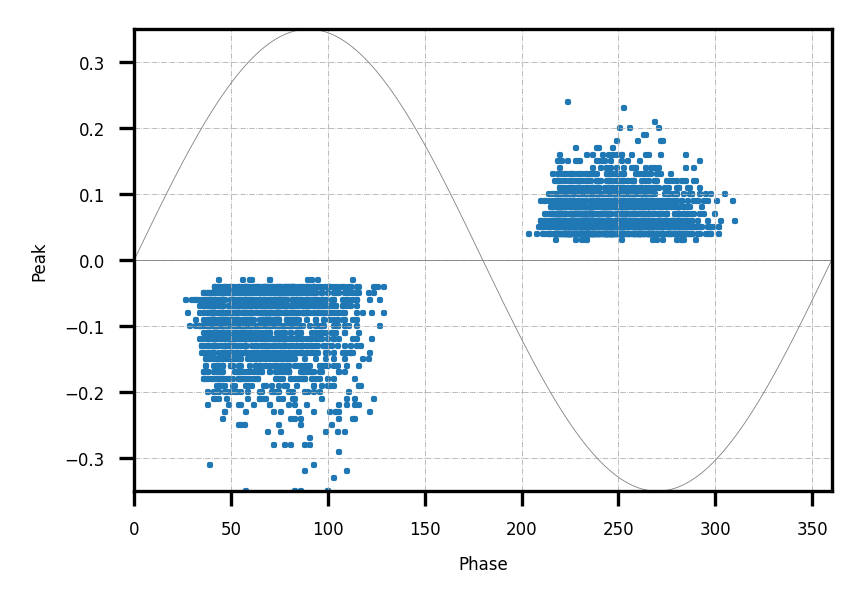

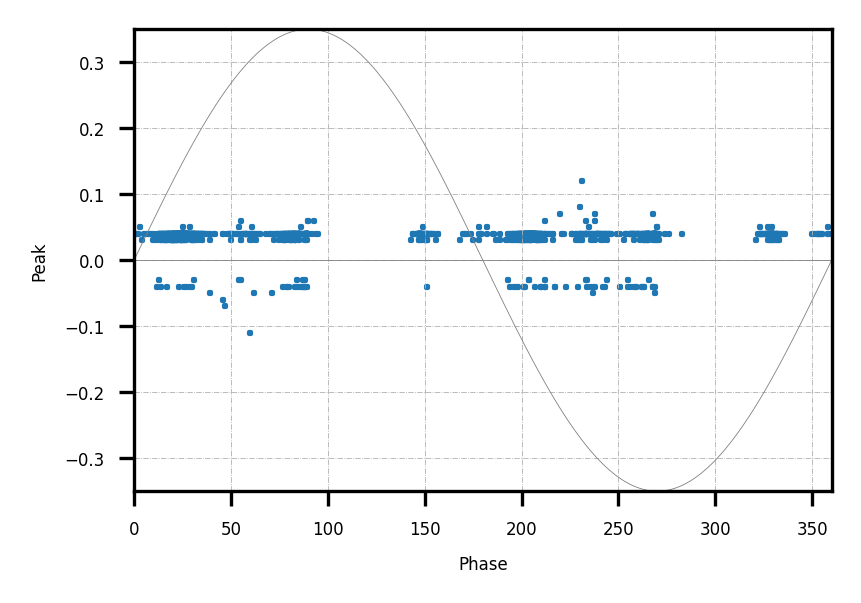

In [9]:
for onecluster in cluster_res:
    update_fig(onecluster['prpd'], max_ampl)

In [10]:
Noise = []
Corona = []
Internal = []
for idx, onecluster in enumerate(cluster_res):
    figlabel = input('Noise=0 Corona=1 Internal=2')
    if figlabel == '0':
        Noise.append(idx)
    elif figlabel == '1':
        Corona.append(idx)
    elif figlabel == '2':
        Internal.append(idx)
    else:
        raise Exception('wrong input!')

In [35]:
# prpd_noise = np.array([])
# prpd_corona = np.array([])
# prpd_internal = np.array([])
# waveform_noise = np.array([])
# waveform_corona = np.array([])
# waveform_internal = np.array([])

prpd_noise = []
prpd_corona = []
prpd_internal = []
waveform_noise = []
waveform_corona = []
waveform_internal = []


for i in range(len(clusteridx)):
    if clusteridx[i] in Noise:
        prpd_noise.append(prpd_list[i])
        waveform_noise.append(waveform_list[i])
    elif clusteridx[i] in Corona:
        prpd_corona.append(prpd_list[i])
        waveform_corona.append(waveform_list[i])
    elif clusteridx[i] in Internal:
        prpd_internal.append(prpd_list[i])
        waveform_internal.append(waveform_list[i])

prpd_noise = np.array(prpd_noise)
prpd_corona = np.array(prpd_corona)
prpd_internal = np.array(prpd_internal)
waveform_noise = np.array(waveform_noise)
waveform_corona = np.array(waveform_corona)
waveform_internal = np.array(waveform_internal)

# noise
data = np.loadtxt('/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/noise/prpd.csv',delimiter=",")
if data.shape[0]<=1:
    np.savetxt("/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/noise/prpd.csv",prpd_noise,delimiter=",")
else:
    data = np.append(data, prpd_noise, axis=0)
    np.savetxt("/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/noise/prpd.csv",data,delimiter=",")

data = np.loadtxt(
    '/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/noise/waveform.csv',
    delimiter=",")
if data.shape[0] <= 1:
    np.savetxt(
        "/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/noise/waveform.csv",
        waveform_noise,
        delimiter=",")
else:
    data = np.append(data, waveform_noise, axis=0)
    np.savetxt(
        "/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/noise/waveform.csv",
        data,
        delimiter=",")

# corona
data = np.loadtxt(
    '/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/corona/prpd.csv',
    delimiter=",")
if data.shape[0] <= 1:
    np.savetxt(
        "/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/corona/prpd.csv",
        prpd_corona,
        delimiter=",")
else:
    data = np.append(data, prpd_corona, axis=0)
    np.savetxt(
        "/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/corona/prpd.csv",
        data,
        delimiter=",")

data = np.loadtxt(
    '/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/corona/waveform.csv',
    delimiter=",")
if data.shape[0] <= 1:
    np.savetxt(
        "/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/corona/waveform.csv",
        waveform_corona,
        delimiter=",")
else:
    data = np.append(data, waveform_corona, axis=0)
    np.savetxt(
        "/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/corona/waveform.csv",
        data,
        delimiter=",")

# internal
data = np.loadtxt(
    '/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/internal/prpd.csv',
    delimiter=",")
if data.shape[0] <= 1:
    np.savetxt(
        "/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/internal/prpd.csv",
        prpd_internal,
        delimiter=",")
else:
    data = np.append(data, prpd_internal, axis=0)
    np.savetxt(
        "/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/internal/prpd.csv",
        data,
        delimiter=",")

data = np.loadtxt(
    '/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/internal/waveform.csv',
    delimiter=",")
if data.shape[0] <= 1:
    np.savetxt(
        "/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/internal/waveform.csv",
        waveform_internal,
        delimiter=",")
else:
    data = np.append(data, waveform_internal, axis=0)
    np.savetxt(
        "/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/internal/waveform.csv",
        data,
        delimiter=",")




# with open('/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/noise/prpd.csv','a') as f:
#     for i in range(len(prpd_noise)):
#         f.write(str(prpd_noise[i]) + '\n')


# with open('/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/noise/waveform.csv', 'a') as f:
#     for i in range(len(waveform_noise)):
#         f.write(str(waveform_noise[i]) + '\n')

# with open('/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/corona/prpd.csv', 'a') as f:
#     for i in range(len(prpd_corona)):
#         f.write(str(prpd_corona[i]) + '\n')
# with open('/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/corona/waveform.csv', 'a') as f:
#     for i in range(len(waveform_corona)):
#         f.write(str(waveform_corona[i]) + '\n')

# with open('/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/internal/prpd.csv', 'a') as f:
#     for i in range(len(prpd_internal)):
#         f.write(str(prpd_internal[i]) + '\n')
# with open(
#         '/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/data/internal/waveform.csv',
#         'a') as f:
#     for i in range(len(waveform_internal)):
#         f.write(str(waveform_internal[i]) + '\n')


In [29]:
prpd_noise.shape

(1566, 2)